In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pprint
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import json
import models
from sweeps.sweep_utils import *

In [2]:
hbm_capacity_list, hbm_bandwidth_list, matrix_flops_list, vector_flops_list, params = sweep_flops_cap_bw() # sweep over flops, caps, bws
numx=len(hbm_capacity_list)
numy=len(matrix_flops_list)
print('Total configs = ', numx * numy)
print('HBM capacity = ', hbm_capacity_list)
print('FLOPs = ', matrix_flops_list)

Total configs =  220
HBM capacity =  [ 80.         100.33333333 120.66666667 141.         158.
 175.         192.         256.         320.         384.        ]
FLOPs =  [ 312.          408.77142857  505.54285714  602.31428571  699.08571429
  795.85714286  892.62857143  989.4        1205.2        1421.
 1636.8        1852.6        2068.4        2284.2        2500.
 2678.57142857 2857.14285714 3035.71428571 3214.28571429 3392.85714286
 3571.42857143 3750.        ]


model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples
b200 tim = None


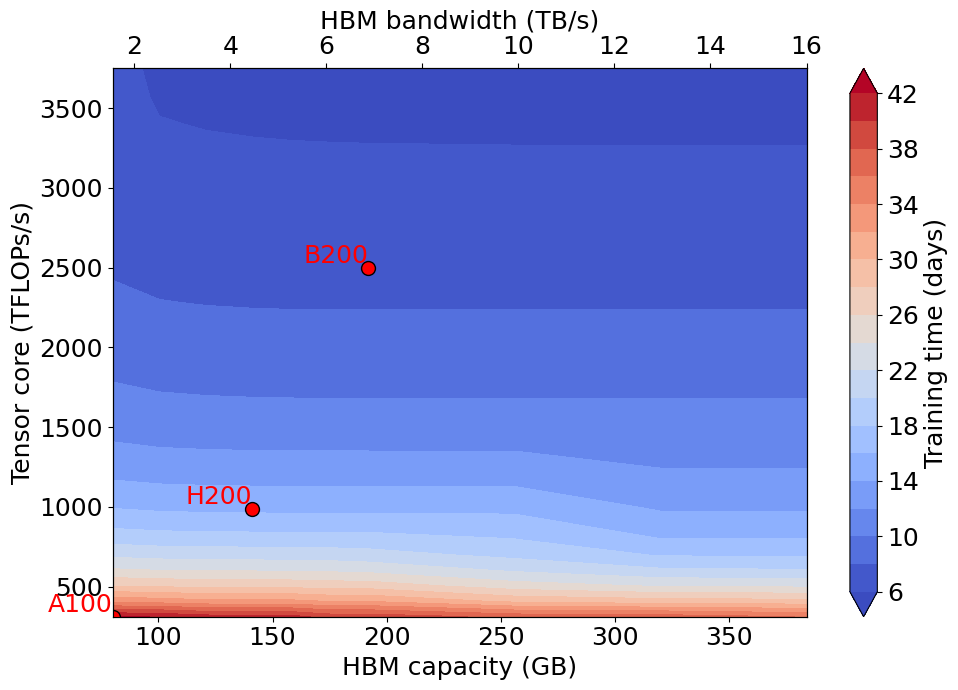

In [3]:
model_str = 'gpt3_1T'
model = models.models[model_str]
par_strat = '1d'
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096

I = np.linspace(0, numx-1, numx)
J = np.linspace(0, numy-1, numy)

F, B = np.meshgrid(hbm_capacity_list, matrix_flops_list, indexing='ij')
T = []
check_at_gpu = 8192

t_b200 = None
for st, p in enumerate(params):
    sys_str = 'B200-{}'.format(str(st))
    
    x = np.load('../outputs/sweeps/sweep_flop_cap_{}_{}_{}.npy'.format(par_strat, model_str, sys_str), allow_pickle=True)
    nvc = 0
    for nvs, t_max, t_min, n_gpus, configs in x:
        if len(t_max) == 0 or (check_at_gpu not in n_gpus):
            T.append(np.nan)
            continue
        time = [(num_samples / tm) / (3600 * 24) for tm in t_max]
        idx = list(n_gpus).index(check_at_gpu)
        T.append(time[idx])        
        nvc += 1

print('b200 tim = {}'.format(t_b200))
T = np.array(T).reshape(B.shape)
fig, ax1 = plt.subplots(figsize=(10, 7), tight_layout=True)
contour = ax1.contourf(F, B, T, levels=20, cmap='coolwarm', extend='both')
cbar = plt.colorbar(contour, ax=ax1)
cbar.set_label('Training time (days)', fontsize=18)
cbar.ax.tick_params(labelsize=18) 

# Label axes
ax1.set_ylabel('Tensor core (TFLOPs/s)', fontsize=18)
ax1.set_xlabel('HBM capacity (GB)', fontsize=18)
ax1.tick_params(axis='both', labelsize=18)
ax1.set_ylim(matrix_flops_list[0],matrix_flops_list[-1])
ax1.set_xlim(hbm_capacity_list[0],hbm_capacity_list[-1])

data_points = [(80,312), (141,990), (192, 2500)]

labels = ['A100', 'H200', 'B200']
colors = ['red', 'red', 'red']

for (x, y), label, color in zip(data_points, labels, colors):
    plt.scatter(x, y, color=color, s=100, edgecolor='black', zorder=5)
    plt.text(x, y, label, fontsize=18, ha='right', va='bottom', color=color, zorder=10)

# Create second x-axis at the top for c values
ax2 = ax1.twiny()
ax2.set_xlim(hbm_bandwidth_list[0]/1E3,hbm_bandwidth_list[-1]/1E3)
ax2.set_xlabel('HBM bandwidth (TB/s)', fontsize=18)
ax2.tick_params(axis='x', labelsize=18)
